# Overview

### `clean_us_data.ipynb`: Fix data inconsistencies in the raw time series data from [`etl_us_data.ipynb`](./etl_us_data.ipynb).

Inputs:
* `outputs/us_counties.csv`: Raw county-level time series data for the United States, produced by running [etl_us_data.ipynb](./etl_us_data.ipynb)
* `outputs/us_counties_meta.json`: Column type metadata for reading `data/us_counties.csv` with `pd.read_csv()`
* `inputs/co-est2019-alldata.csv`: County-level population data from the U.S. Census Bureau, converted to CSV format with Excel (Original public domain data file available in many proprietary formats [here](https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html)).
* [`https://github.com/thecityny/covid-19-nyc-data`](https://github.com/thecityny/covid-19-nyc-data): New York newspaper [THE CITY](https://thecity.nyc/)'s digest of the daily reports that the New York City health department posts at [`https://github.com/nychealth/coronavirus-data`](https://github.com/nychealth/coronavirus-data).

Outputs:
* `outputs/us_counties_clean.csv`: The contents of `outputs/us_counties.csv` after data cleaning
* `outputs/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

**Note:** You can redirect these input and output files by setting the environment variables `COVID_INPUTS_DIR` and `COVID_OUTPUTS_DIR` to replacement values for the prefixes `inputs` and `outputs`, respectively, in the above paths.

# Read in the CSV file and apply the saved type information

In [1]:
# Initialization boilerplate

import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
import sklearn.metrics
import matplotlib.pyplot as plt

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
_INPUTS_DIR = os.getenv("COVID_INPUTS_DIR", "inputs")

In [2]:
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_raw = pd.read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])

# Restore the Pandas index
cases_vertical = cases_raw.set_index(["FIPS", "Date"], verify_integrity=True)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-17  Wyoming   Weston        6927          0       0          0   
      2020-05-18  Wyoming   Weston        6927          0       0          0   
      2020-05-19  Wyoming   Weston        6927          0       0          0   
      2020-05-20  Wyoming   Weston        6927          0       0          0   
      2020-05-21  Wyoming   Weston        6927          0       0          0   

                  Confirmed_NYT  Deaths_NYT  
FIPS  Date                                   
1001  2020-01-22           <NA>        <NA>  
      2020-01-23           <NA>        <NA>  
      2020-01-24           <NA>        <NA>  
      2020-01-25           <NA>        <NA>  
      2020-01-26           <NA>        <NA>  
...                         ...         ...  
56045 2020-05-17           <NA>        <NA>  
      2020-05-18           <NA>        <NA>  
      2020-05-19           <NA>        <NA>  
      2020-05-20           <NA>        <NA>  
      2020-05-21           <NA>        <NA>  

[380182 rows x 8 columns]

In [3]:
# Replace the missing values in the secondary dataset with 0's.
cases_vertical["Confirmed_NYT"].fillna(0, inplace=True)
cases_vertical["Deaths_NYT"].fillna(0, inplace=True)
cases_vertical["Confirmed_NYT"] = cases_vertical["Confirmed_NYT"].astype("int64")
cases_vertical["Deaths_NYT"] = cases_vertical["Deaths_NYT"].astype("int64")
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-17  Wyoming   Weston        6927          0       0          0   
      2020-05-18  Wyoming   Weston        6927          0       0          0   
      2020-05-19  Wyoming   Weston        6927          0       0          0   
      2020-05-20  Wyoming   Weston        6927          0       0          0   
      2020-05-21  Wyoming   Weston        6927          0       0          0   

                  Confirmed_NYT  Deaths_NYT  
FIPS  Date                                   
1001  2020-01-22              0           0  
      2020-01-23              0           0  
      2020-01-24              0           0  
      2020-01-25              0           0  
      2020-01-26              0           0  
...                         ...         ...  
56045 2020-05-17              0           0  
      2020-05-18              0           0  
      2020-05-19              0           0  
      2020-05-20              0           0  
      2020-05-21              0           0  

[380182 rows x 8 columns]

In [4]:
# Collapse each time series down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, ["Confirmed", "Deaths", "Recovered", 
                                                          "Confirmed_NYT", "Deaths_NYT"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_NYT,Deaths_NYT
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# Note that the previous cell also saved the values from the "Date"
# column of `cases_vertical` into the Python variable `dates`:
dates[:10], dates.shape

(array(['2020-01-22T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
        '2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
        '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
        '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
        '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 (121,))

# Clean up the New York City data

Those silly folks at Johns Hopkins code all of New York city as being
in New York County. Each borough is actually in a different county
with a different FIPS code.

Our secondary data set also merges together all of New York City, so we
can't use its data as a substitute.

So we use generate numbers from THE CITY's digest of the New York City 
health department's fine-grained numbers.
For dates before and after the availability of official numbers by borough,
we extrapolate from the Johns Hopkins data for all of New York City.

In [6]:
# First, double-check that the error is still there.
max_bronx_confirmed = cases.loc[36005]["Confirmed"].max()
if max_bronx_confirmed > 0:
    raise ValueError("Someone has fixed the problem with the New York data. "
                     "Please disable the fix in this cell.")

print(f"Time series for the Bronx before correction:\n{cases.loc[36005]['Confirmed']}")

Time series for the Bronx before correction:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


## Correct population numbers for New York City

The raw data assigns the entire population of New York City to
New York County.  Load the actual population from some Census Bureau data.

In [7]:
# Population by county, from U.S. Census Bureau, converted to CSV with Excel;
# hence the cp1255 encoding.
# Original public domain data file available in many proprietary formats
# at https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
population_data_file = os.path.join(_INPUTS_DIR, "co-est2019-alldata.csv")
population_raw = pd.read_csv(population_data_file, encoding="cp1255")

# Filter out state-level totals
county_population = population_raw[population_raw["COUNTY"] != 0]

# Convert FIPS code to the same format as the other tables
county_population.insert(0, "FIPS", 
                         (county_population["STATE"] * 1000)
                         + county_population["COUNTY"])

# Filter down to just the columns we need
county_population = county_population[county_population["FIPS"] >= 1000][["FIPS", "POPESTIMATE2019"]]

# Pull the populations for the New York city counties out of the above
# dataframe.
new_york_county_fips = 36061
nyc_fips = [
    36005,  # Bronx County
    36047,  # Kings County
    new_york_county_fips,  # New York County
    36081,  # Queens County
    36085,  # Richmond County
]

nyc_populations = [
    county_population[county_population["FIPS"] == f]["POPESTIMATE2019"].iloc[0]
    for f in nyc_fips
]
total_population = sum(nyc_populations)


# Before:
cases.loc[nyc_fips][["State", "County", "Population"]]

,State,County,Population
FIPS,,,
36005,New York,Bronx,1418207
36047,New York,Kings,2559903
36061,New York,New York,8336817
36081,New York,Queens,2253858
36085,New York,Richmond,476143


In [8]:
ny_county_population = county_population[county_population["FIPS"] == new_york_county_fips]["POPESTIMATE2019"].iloc[0]

# Need to copy the series and modify the copy to avoid Pandas' "A value
# is trying to be set on a copy of a slice from a DataFrame" warning.
new_population = cases["Population"].copy(deep=True)
new_population.loc[new_york_county_fips] = ny_county_population

cases["Population"] = new_population

# After:
cases.loc[nyc_fips][["State", "County", "Population"]]

,State,County,Population
FIPS,,,
36005,New York,Bronx,1418207
36047,New York,Kings,2559903
36061,New York,New York,1628706
36081,New York,Queens,2253858
36085,New York,Richmond,476143


## Obtain New York City numbers by borough

The New York City Department of Health and Mental Hygiene (DOHMH) publishes a breakdown
of the latest case numbers by borough, updated about once a day.
[THE CITY](https://thecity.nyc/), an independent newpaper, maintains an
archive of the DOHMH numbers over time.

In [9]:
# Download THE CITY's digest of New York numbers by borough of residence.
_THE_CITY_CSV_URL = ("https://github.com/thecityny/covid-19-nyc-data/" 
                     + "raw/master/borough.csv")
nyc_raw = pd.read_csv(_THE_CITY_CSV_URL, parse_dates=["timestamp"])
nyc_raw

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
0,2020-03-12 04:00:00+00:00,cases,10,24,25,17,5,7,88
1,2020-03-13 04:00:00+00:00,cases,13,24,35,26,5,34,137
2,2020-03-15 04:00:00+00:00,cases,21,53,72,78,16,29,269
3,2020-03-16 04:00:00+00:00,cases,34,62,111,118,19,120,464
4,2020-03-17 22:00:00+00:00,cases,106,236,290,248,42,1,923
...,...,...,...,...,...,...,...,...,...
447,2020-05-16 22:00:00+00:00,deaths,3369,4847,2147,4750,764,11,15888
448,2020-05-16 22:00:00+00:00,deaths-underlying,3062,3690,1592,3685,536,6,12571
449,2020-05-16 22:00:00+00:00,deaths-no-underlying,12,25,8,49,2,0,96
450,2020-05-16 22:00:00+00:00,deaths-pending-underlying,295,1132,547,1016,226,5,3221


In [10]:
nyc_cases = nyc_raw[nyc_raw["type"] == "cases"]
nyc_deaths = nyc_raw[nyc_raw["type"] == "deaths"]
nyc_probable_deaths = nyc_raw[nyc_raw["type"] == "deaths-probable"]
nyc_cases

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
0,2020-03-12 04:00:00+00:00,cases,10,24,25,17,5,7,88
1,2020-03-13 04:00:00+00:00,cases,13,24,35,26,5,34,137
2,2020-03-15 04:00:00+00:00,cases,21,53,72,78,16,29,269
3,2020-03-16 04:00:00+00:00,cases,34,62,111,118,19,120,464
4,2020-03-17 22:00:00+00:00,cases,106,236,290,248,42,1,923
...,...,...,...,...,...,...,...,...,...
417,2020-05-12 22:00:00+00:00,cases,41953,50346,22889,57178,12749,91,185206
424,2020-05-13 22:00:00+00:00,cases,42222,50674,23056,57459,12791,91,186293
431,2020-05-14 22:00:00+00:00,cases,42656,51131,23274,57865,12832,90,187848
438,2020-05-15 22:00:00+00:00,cases,42966,51509,23428,58170,12867,91,189031


In [11]:
nyc_deaths

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
9,2020-03-22 13:54:00+00:00,deaths,14,14,10,21,4,0,63
13,2020-03-23 21:00:00+00:00,deaths,28,27,19,40,11,0,125
16,2020-03-24 21:00:00+00:00,deaths,41,42,30,61,18,0,192
19,2020-03-25 13:15:00+00:00,deaths,43,43,30,65,18,0,199
21,2020-03-25 21:30:00+00:00,deaths,60,64,43,92,21,0,280
...,...,...,...,...,...,...,...,...,...
419,2020-05-12 22:00:00+00:00,deaths,3268,4636,2022,4571,727,9,15233
426,2020-05-13 22:00:00+00:00,deaths,3284,4676,2048,4595,737,9,15349
433,2020-05-14 22:00:00+00:00,deaths,3293,4705,2057,4610,748,9,15422
440,2020-05-15 22:00:00+00:00,deaths,3344,4813,2126,4707,756,10,15756


In [12]:
nyc_probable_deaths

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
215,2020-04-13 20:30:00+00:00,deaths-probable,350,656,335,527,50,9,1927
222,2020-04-14 22:00:00+00:00,deaths-probable,368,725,366,573,56,12,2100
229,2020-04-15 22:00:00+00:00,deaths-probable,382,665,300,604,60,10,2021
236,2020-04-16 22:00:00+00:00,deaths-probable,443,764,331,672,69,12,2291
243,2020-04-17 22:00:00+00:00,deaths-probable,457,801,343,712,75,10,2398
250,2020-04-18 22:00:00+00:00,deaths-probable,505,865,362,764,79,11,2586
257,2020-04-19 22:00:00+00:00,deaths-probable,533,917,378,805,85,11,2729
264,2020-04-20 22:00:00+00:00,deaths-probable,575,988,393,875,90,10,2931
271,2020-04-21 22:00:00+00:00,deaths-probable,621,1054,430,913,100,11,3129
278,2020-04-22 22:00:00+00:00,deaths-probable,665,1108,446,943,108,12,3282


## Regenerate the New York City time series

Use the NYC health department numbers when possible. Extrapolate fro the JHU data for dates where borough-level numbers are unavailable or unreliable.

In [13]:
# Pick points from the THE CITY data that align with timestamps
# in the JHU data.

# Earliest dates we try to align with.
nyc_cases_start = np.datetime64("2020-03-17")
nyc_deaths_start = np.datetime64("2020-04-15")

nyc_cases_dates_to_align = pd.DatetimeIndex(dates[dates >= nyc_cases_start]).tz_localize("UTC")
nyc_deaths_dates_to_align = pd.DatetimeIndex(dates[dates >= nyc_deaths_start]).tz_localize("UTC")

borough_name_to_fips = {
    "bronx": 36005,  # Bronx County
    "brooklyn": 36047,  # Kings County
    "manhattan": new_york_county_fips,  # New York County
    "queens": 36081,  # Queens County
    "staten_island": 36085,  # Richmond County
}

nyc_confirmed_jhu = cases["Confirmed"].loc[new_york_county_fips].copy()
nyc_deaths_jhu = cases["Deaths"].loc[new_york_county_fips].copy()

fips_to_confirmed_tail = {}
for borough_name, fips in borough_name_to_fips.items():
    cases_tail = np.zeros(shape=len(nyc_cases_dates_to_align), dtype=np.int64)
    for _, row in nyc_cases.iterrows():
        ts = row["timestamp"]
        value = row[borough_name]
        day_plus_one = np.argmax(nyc_cases_dates_to_align >= ts)
        if day_plus_one > 0:
            cases_tail[day_plus_one - 1] = value
    # The detailed NYC data is often a day or two behind JHU. Use the 
    # proportional increase from the corresponding JHU data points to
    # extrapolate missing values at the tail end of the new tail.
    tail_offset = len(nyc_confirmed_jhu) - len(cases_tail)
    for i in range(1, len(cases_tail)):
        if 0 == cases_tail[i]:
            ratio = (nyc_confirmed_jhu[tail_offset + i] 
                     / nyc_confirmed_jhu[tail_offset + i - 1])
            cases_tail[i] = cases_tail[i-1] * ratio
    fips_to_confirmed_tail[fips] = cases_tail

fips_to_confirmed = {}    
first_day_total_confirmed = sum([a[0] for a in fips_to_confirmed_tail.values()])
for borough_name, fips in borough_name_to_fips.items():
    tail = fips_to_confirmed_tail[fips]
    first_day_ratio = tail[0] / first_day_total_confirmed
    before = (nyc_confirmed_jhu * first_day_ratio).astype(np.int64)
    after = before.copy()
    after[-len(tail):] = tail
    fips_to_confirmed[fips] = after

fips_to_deaths_tail = {}
for borough_name, fips in borough_name_to_fips.items():
    deaths_tail = np.zeros(shape=len(nyc_deaths_dates_to_align), dtype=np.int64)
    for _, row in nyc_deaths.iterrows():
        ts = row["timestamp"]
        value = row[borough_name]
        day_plus_one = np.argmax(nyc_deaths_dates_to_align >= ts)
        if day_plus_one > 0:
            deaths_tail[day_plus_one - 1] = value            
    for _, row in nyc_probable_deaths.iterrows():
        ts = row["timestamp"]
        value = row[borough_name]
        day_plus_one = np.argmax(nyc_deaths_dates_to_align >= ts)
        if day_plus_one > 0:
            deaths_tail[day_plus_one - 1] += value
    tail_offset = len(nyc_deaths_jhu) - len(deaths_tail)
    for i in range(1, len(deaths_tail)):
        if 0 == deaths_tail[i]:
            ratio = (nyc_deaths_jhu[tail_offset + i] 
                     / nyc_deaths_jhu[tail_offset + i - 1])
            deaths_tail[i] = deaths_tail[i-1] * ratio
    fips_to_deaths_tail[fips] = deaths_tail
    
print(fips_to_deaths_tail[36005])

fips_to_deaths = {}
first_day_total_deaths = sum([a[0] for a in fips_to_deaths_tail.values()])
for borough_name, fips in borough_name_to_fips.items():
    tail = fips_to_deaths_tail[fips]
    
    # The JHU data counts considerably more deaths than the NYC health
    # department's. Assume that the city's own data is more accurate and
    # scale the early JHU numbers to match.
    first_day_jhu_deaths = nyc_deaths_jhu[-len(tail)]
    
    first_day_ratio = tail[0] / first_day_total_deaths
    jhu_nyc_ratio = first_day_jhu_deaths / first_day_total_deaths
    before = (nyc_deaths_jhu * first_day_ratio / jhu_nyc_ratio).astype(np.int64)
    after = before.copy()
    after[-len(tail):] = tail
    fips_to_deaths[fips] = after
#     print(borough_name)
#     print(f"{tail[0]} of {first_day_total_deaths} (vs {first_day_jhu_deaths})")
#     print(f"All of NYC:\n{nyc_deaths_jhu}")
#     print(f"Before:\n{before}")
#     print(f"After:\n{after}")

#cases_vertical.loc[new_york_county_fips].iloc[50:100]

# Copy to avoid the chained indexing warning.
# (https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)
new_confirmed = cases["Confirmed"].copy(deep=True)
for fips, series in fips_to_confirmed.items():
    new_confirmed.loc[fips] = series
cases["Confirmed"] = new_confirmed
new_deaths = cases["Deaths"].copy(deep=True)
for fips, series in fips_to_deaths.items():
    new_deaths.loc[fips] = series
cases["Deaths"] = new_deaths

[2131 2245 2374 2480 2569 2719 2828 2937 3029 3134 3209 3274 3345 3432
 3485 3598 3655 3709 3750 3820 3869 3919 3969 4012 4042 4077 4116 4145
 4161 4192 4221 4252 4281 4298 4314 4323 4337]


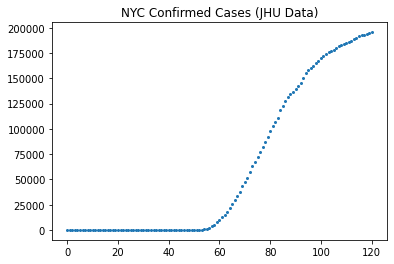

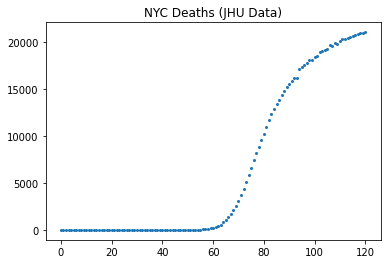

In [14]:
# NYC before
plt.title("NYC Confirmed Cases (JHU Data)")
plt.plot(nyc_confirmed_jhu, "o", markersize=2)
plt.show()
plt.title("NYC Deaths (JHU Data)")
plt.plot(nyc_deaths_jhu, "o", markersize=2)
plt.show()

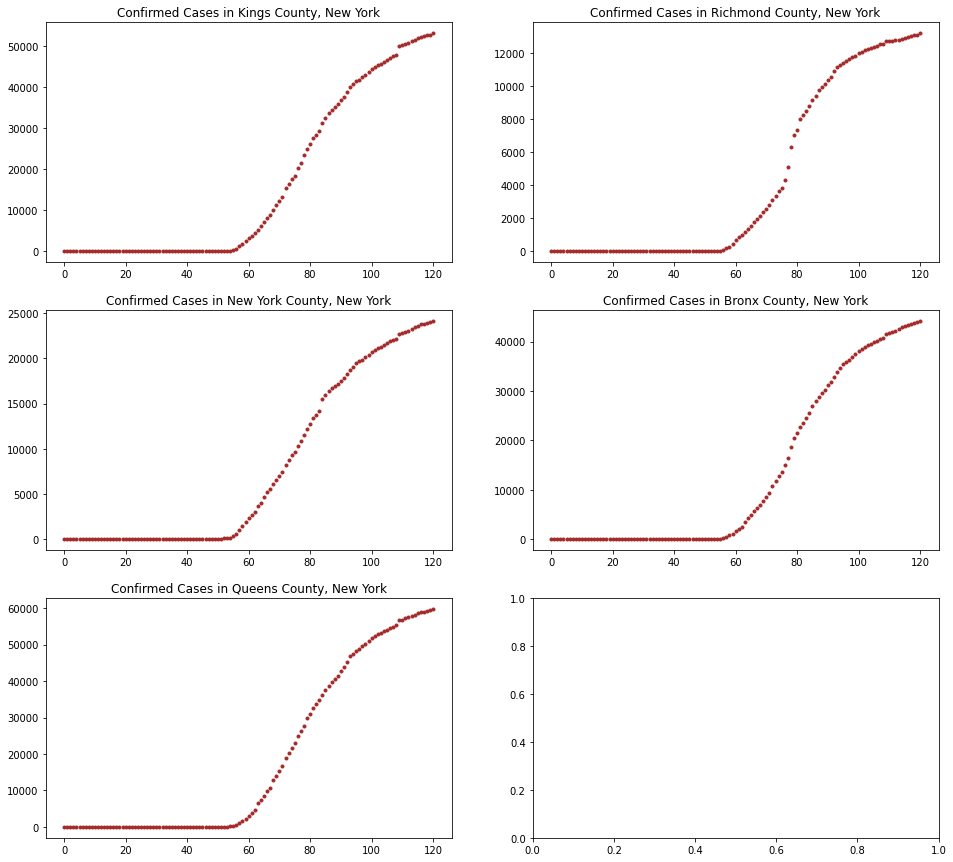

In [15]:
# NYC confirmed cases after cleaning:
util.graph_examples(cases.loc[nyc_fips], "Confirmed", {}, num_to_pick=5)

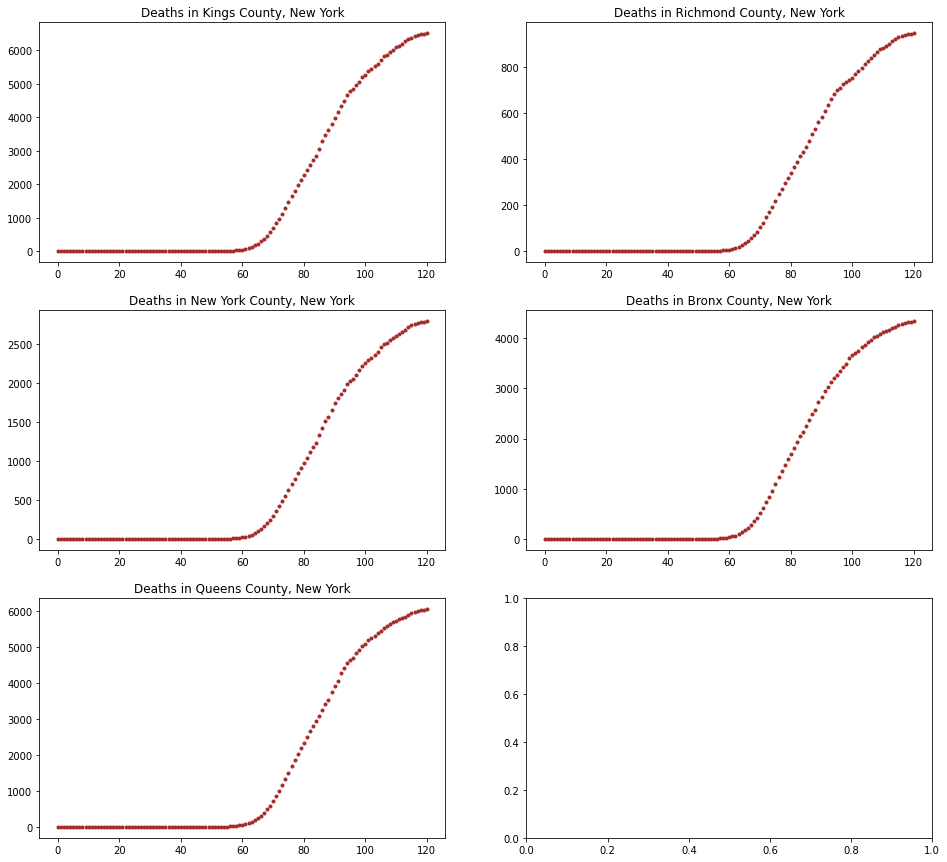

In [16]:
# NYC deaths by county after cleaning:
util.graph_examples(cases.loc[nyc_fips], "Deaths", {}, num_to_pick=5)

# Clean up the Rhode Island data

The Johns Hopkins data reports zero deaths in most of Rhode Island. Use 
the secondary data set from the New York Times for Rhode Island.

Before:


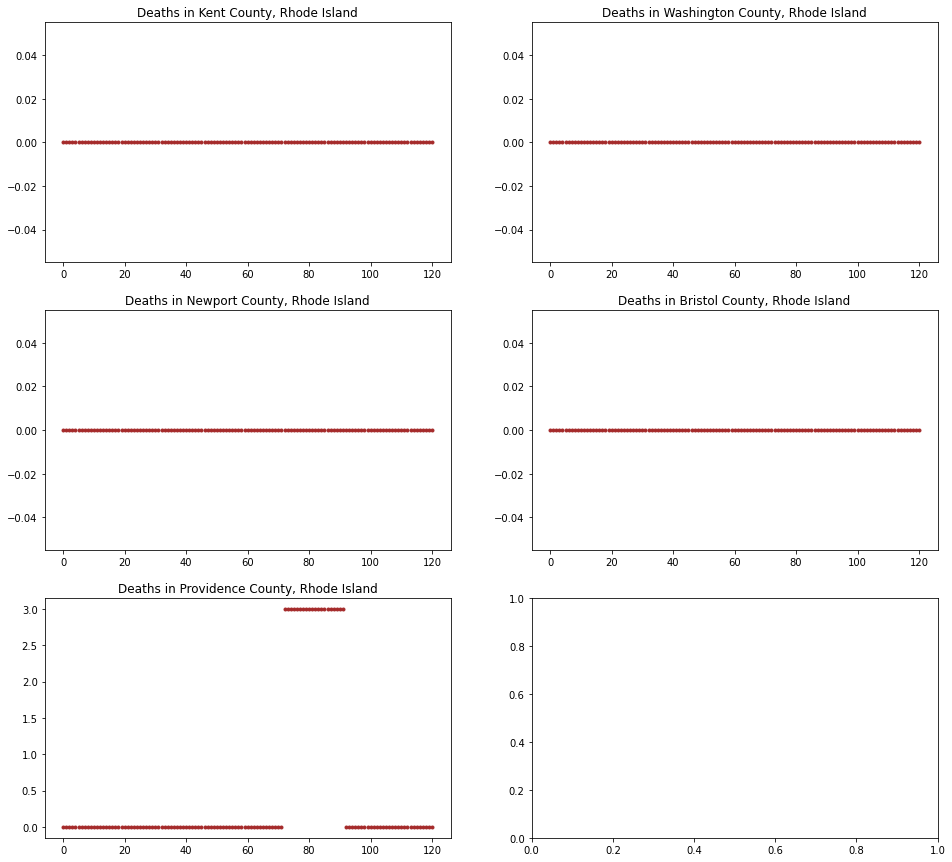

In [17]:
print("Before:")
util.graph_examples(cases, "Deaths", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Rhode Island"))

After:


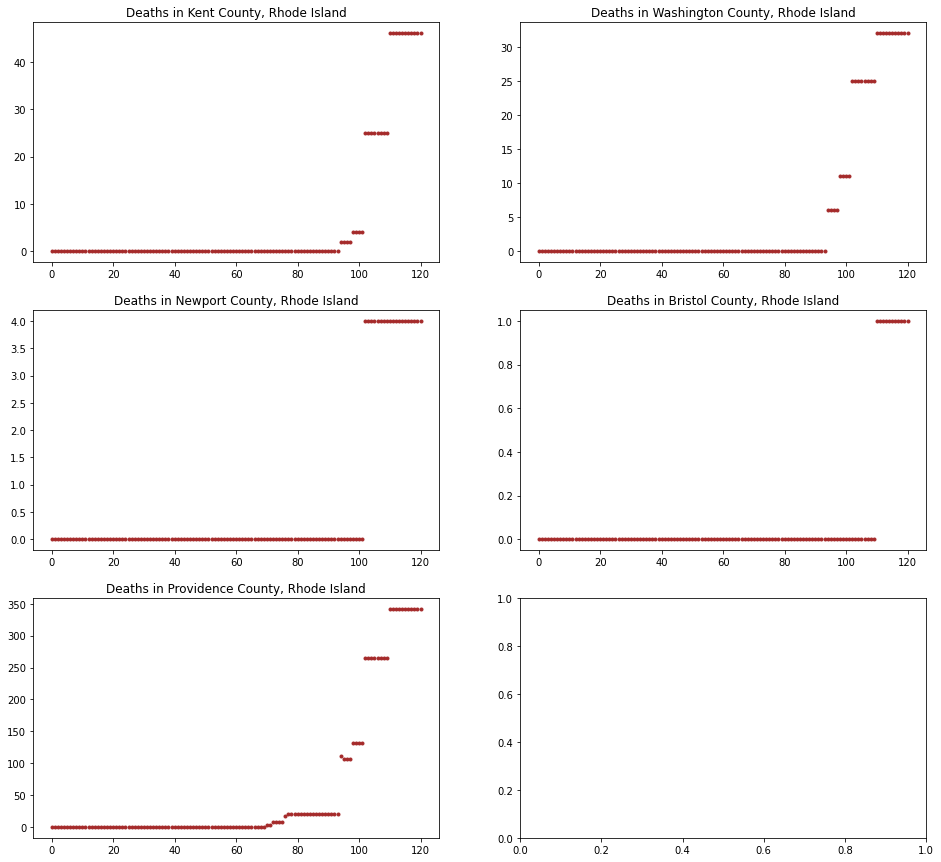

In [18]:
# Use our secondary data set for all Rhode Island data.
ri_fips = cases[cases["State"] == "Rhode Island"].index.values.tolist()
for colname in ["Confirmed", "Deaths"]:
    new_series = cases[colname].copy(deep=True)
    for fips in ri_fips:
        new_series.loc[fips] = cases[colname + "_NYT"].loc[fips]
    cases[colname] = new_series 

# Note that the secondary data set has not "Recovered" time series, so
# we leave those numbers alone for now.

print("After:")
util.graph_examples(cases, "Deaths", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Rhode Island"))

# Clean up the Utah data

The Johns Hopkins data for Utah is missing quite a few data points.
Use the New York Times data for Utah.

Before:


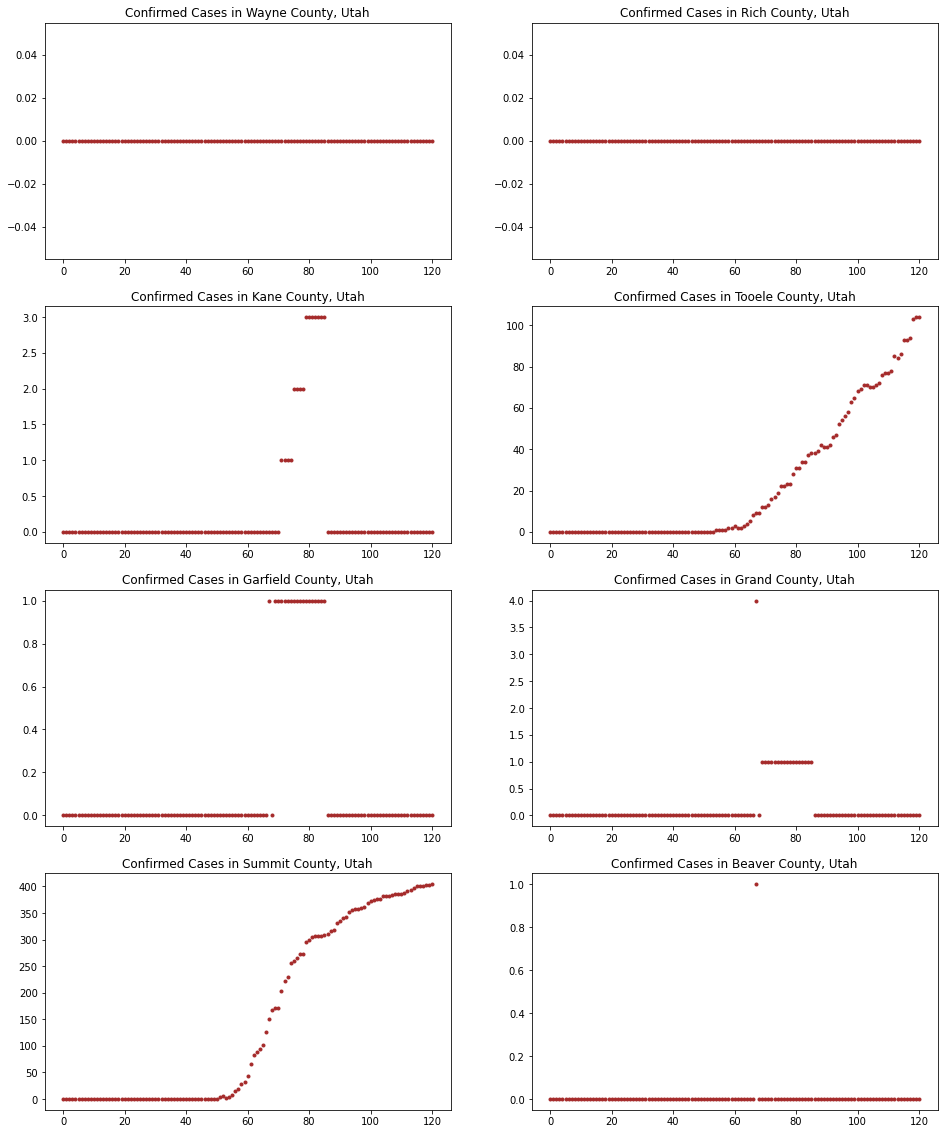

In [19]:
print("Before:")
util.graph_examples(cases, "Confirmed", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Utah"))

After:


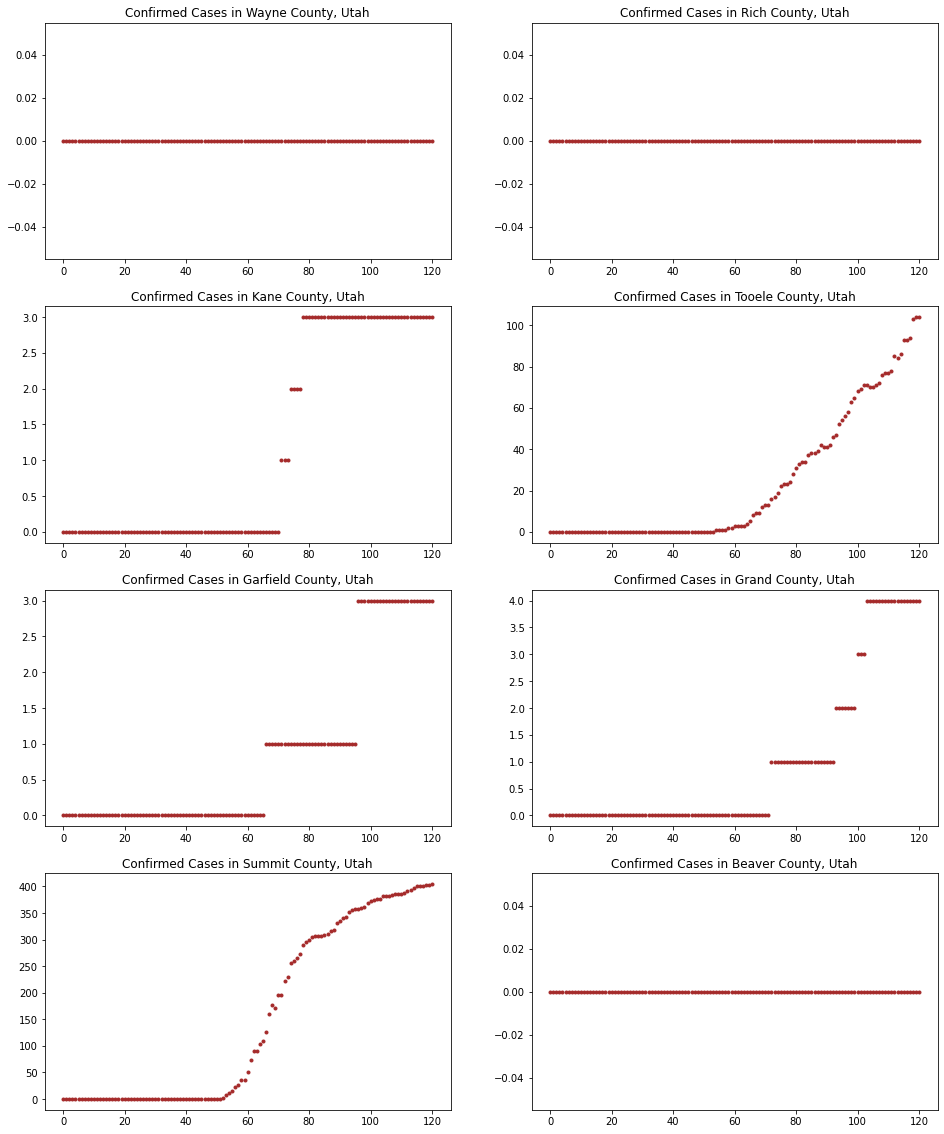

In [20]:
# The Utah time series from the New York Times' data set are more 
# complete, so we use those numbers.
ut_fips = cases[cases["State"] == "Utah"].index.values
for colname in ["Confirmed", "Deaths"]:
    new_series = cases[colname].copy(deep=True)
    for fips in ut_fips:
        new_series.loc[fips] = cases[colname + "_NYT"].loc[fips]
    cases[colname] = new_series 

# Note that the secondary data set has not "Recovered" time series, so
# we leave those numbers alone for now.

print("After:")
util.graph_examples(cases, "Confirmed", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Utah"))

# Flag additional problematic and missing data points

Use heuristics to identify and flag problematic data points across all 
the time series. Generate Boolean masks that show the locations of these
outliers.

In [21]:
# Now we're done with the secondary data set, so drop its columns.
cases = cases.drop(columns=["Confirmed_NYT", "Deaths_NYT"])
cases

,State,County,Population,Confirmed,Deaths,Recovered
FIPS,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [22]:
# Now we need to find and flag obvious data-entry errors.
# We'll start by creating columns of "is outlier" masks.
# We use integers instead of Boolean values as a workaround for
# https://github.com/pandas-dev/pandas/issues/33770

# Start out with everything initialized to "not an outlier"
cases["Confirmed_Outlier"] = tp.TensorArray(np.zeros_like(cases["Confirmed"].values))
cases["Deaths_Outlier"] = tp.TensorArray(np.zeros_like(cases["Deaths"].values))
cases["Recovered_Outlier"] = tp.TensorArray(np.zeros_like(cases["Recovered"].values))

cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


## Flag time series that go from zero to nonzero and back again

One type of anomaly that occurs fairly often involves a time series
jumping from zero to a nonzero value, then back to zero again.

This pattern most likely indicates that a patient was erroneously
classified as COVID-19-positive, but that the county health department
didn't correct its historical data after they found out.

Locate all instances of that pattern and mark the nonzero values
as outliers.

In [23]:
def nonzero_then_zero(series: np.array):
    empty_mask = np.zeros_like(series, dtype=np.int8)
    if series[0] > 0:
        # Special case: first value is nonzero
        return empty_mask
    first_nonzero_offset = 0
    while first_nonzero_offset < len(series):
        if series[first_nonzero_offset] > 0:
            # Found the first nonzero.
            # Find the distance to the next zero value.
            next_zero_offset = first_nonzero_offset + 1
            while (next_zero_offset < len(series)
                   and series[next_zero_offset] > 0):
                next_zero_offset += 1
            
            # Check the length of the run of zeros after
            # dropping back to zero.
            second_nonzero_offset = next_zero_offset + 1
            while (second_nonzero_offset < len(series)
                   and series[second_nonzero_offset] == 0):
                second_nonzero_offset += 1
                
            nonzero_run_len = next_zero_offset - first_nonzero_offset
            second_zero_run_len = second_nonzero_offset - next_zero_offset
            
            # print(f"{first_nonzero_offset} -> {next_zero_offset} -> {second_nonzero_offset}; series len {len(series)}")
            if next_zero_offset >= len(series):
                # Everything after the first nonzero was a nonzero
                return empty_mask
            elif second_zero_run_len <= nonzero_run_len:
                # Series dropped back to zero, but the second zero
                # part was shorter than the nonzero section.
                # In this case, it's more likely that the second run
                # of zero values are actually missing values.
                return empty_mask
            else:
                # Series went zero -> nonzero -> zero -> nonzero
                # or zero -> nonzero -> zero -> [end]
                nonzero_run_mask = empty_mask.copy()
                nonzero_run_mask[first_nonzero_offset:next_zero_offset] = 1  
                return nonzero_run_mask
        first_nonzero_offset += 1   
    # If we get here, the series was all zeros
    return empty_mask
    
for colname in ["Confirmed", "Deaths", "Recovered"]:
    addl_outliers = np.stack([nonzero_then_zero(s) for s in cases[colname]])
    outliers_colname = colname + "_Outlier"
    new_outliers = cases[outliers_colname].values.astype(np.bool) | addl_outliers
    cases[outliers_colname] = tp.TensorArray(new_outliers.astype(np.int8))

# fips = 13297
# print(cases.loc[fips]["Confirmed"])
# print(nonzero_then_zero(cases.loc[fips]["Confirmed"]))

In [24]:
# Let's have a look at which time series acquired the most outliers as 
# a result of the code in the previous cell.
df = cases[["State", "County"]].copy()
df["Confirmed_Num_Outliers"] = np.count_nonzero(cases["Confirmed_Outlier"], axis=1)
counties_with_outliers = df.sort_values("Confirmed_Num_Outliers", ascending=False).head(10)
counties_with_outliers

,State,County,Confirmed_Num_Outliers
FIPS,,,
29215,Missouri,Texas,10
37095,North Carolina,Hyde,9
46041,South Dakota,Dewey,8
32017,Nevada,Lincoln,8
37041,North Carolina,Chowan,5
30027,Montana,Fergus,5
35011,New Mexico,De Baca,4
16061,Idaho,Lewis,4
19053,Iowa,Decatur,3


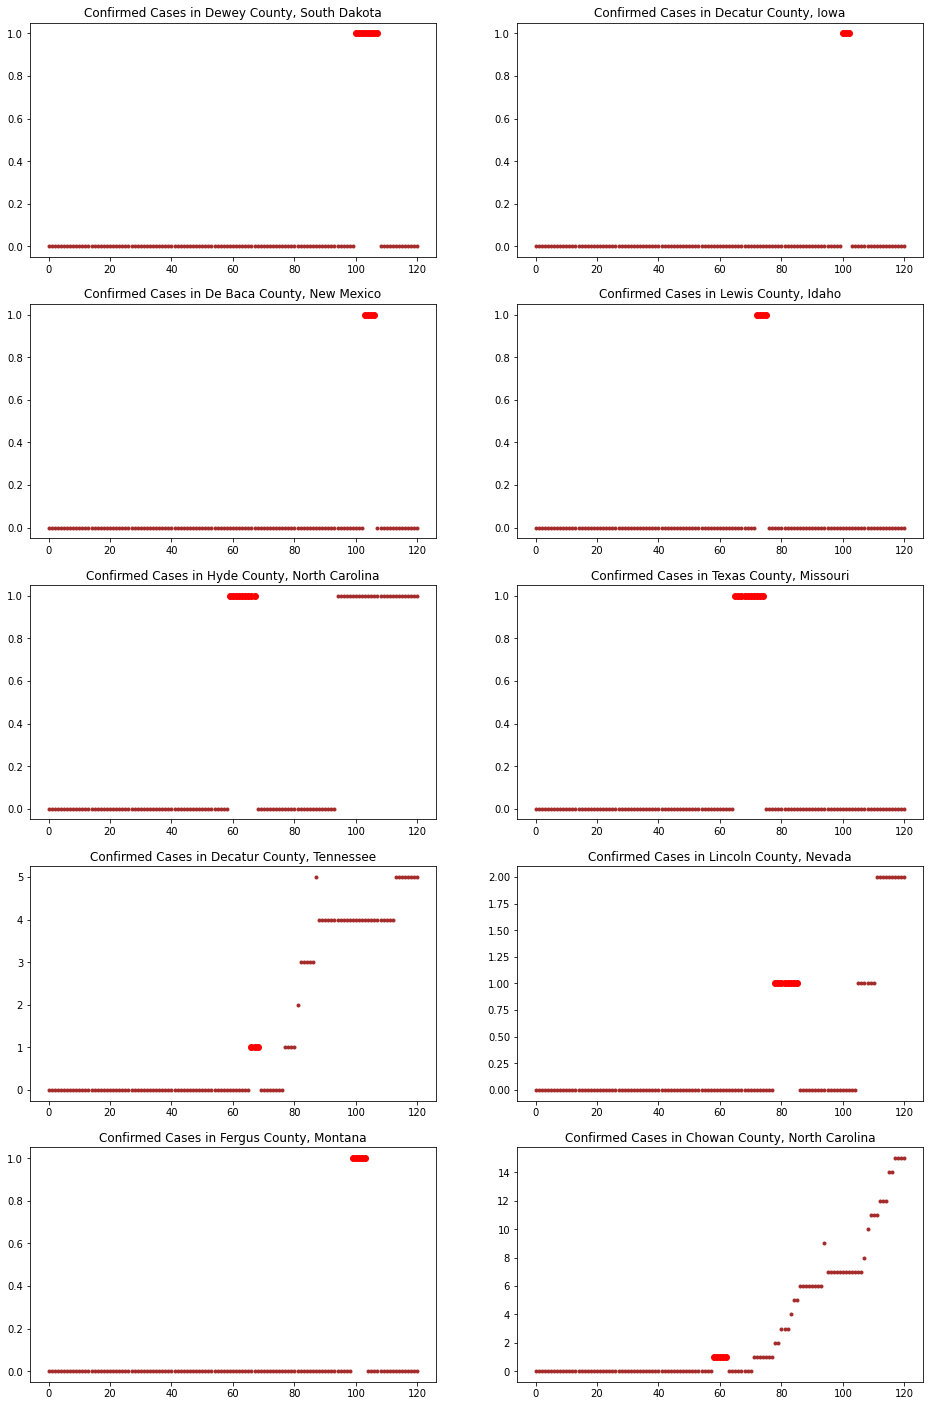

In [25]:
# Plot the couties in the table above, with outliers highlighted.
# The graph_examples() function is defined in util.py.
util.graph_examples(cases, "Confirmed", {}, num_to_pick=10, mask=(cases.index.isin(counties_with_outliers.index)))

## Flag time series that drop to zero, then go back up

Another type of anomaly involves the time series dropping down to 
zero, then going up again. Since all three time series are supposed
to be cumulative counts, this pattern most likely indicates missing
data.

To correct for this problem, we mark any zero values after the
first nonzero, non-outlier values as outliers, across all time series.

In [26]:
def zeros_after_first_nonzero(series: np.array, outliers: np.array):
    nonzero_mask = (series != 0)
    nonzero_and_not_outlier = nonzero_mask & (~outliers)
    first_nonzero = np.argmax(nonzero_and_not_outlier)
    if 0 == first_nonzero and series[0] == 0:
        # np.argmax(nonzero_mask) will return 0 if there are no nonzeros
        return np.zeros_like(series)
    after_nonzero_mask = np.zeros_like(series)
    after_nonzero_mask[first_nonzero:] = True
    return (~nonzero_mask) & after_nonzero_mask

for colname in ["Confirmed", "Deaths", "Recovered"]:
    outliers_colname = colname + "_Outlier"
    addl_outliers = np.stack([zeros_after_first_nonzero(s, o) 
                              for s, o in zip(cases[colname], cases[outliers_colname])])
    new_outliers = cases[outliers_colname].values.astype(np.bool) | addl_outliers
    cases[outliers_colname] = tp.TensorArray(new_outliers.astype(np.int8))

# fips = 47039
# print(cases.loc[fips]["Confirmed"])
# print(cases.loc[fips]["Confirmed_Outlier"])
# print(zeros_after_first_nonzero(cases.loc[fips]["Confirmed"], cases.loc[fips]["Confirmed_Outlier"]))   

In [27]:
# Redo our "top 10 by number of outliers" analysis with the additional outliers
df = cases[["State", "County"]].copy()
df["Confirmed_Num_Outliers"] = np.count_nonzero(cases["Confirmed_Outlier"], axis=1)
counties_with_outliers = df.sort_values("Confirmed_Num_Outliers", ascending=False).head(10)
counties_with_outliers

,State,County,Confirmed_Num_Outliers
FIPS,,,
20003,Kansas,Anderson,27
37173,North Carolina,Swain,21
40149,Oklahoma,Washita,17
51600,Virginia,Fairfax City,13
26033,Michigan,Chippewa,10
29215,Missouri,Texas,10
31045,Nebraska,Dawes,9
37095,North Carolina,Hyde,9
32017,Nevada,Lincoln,8


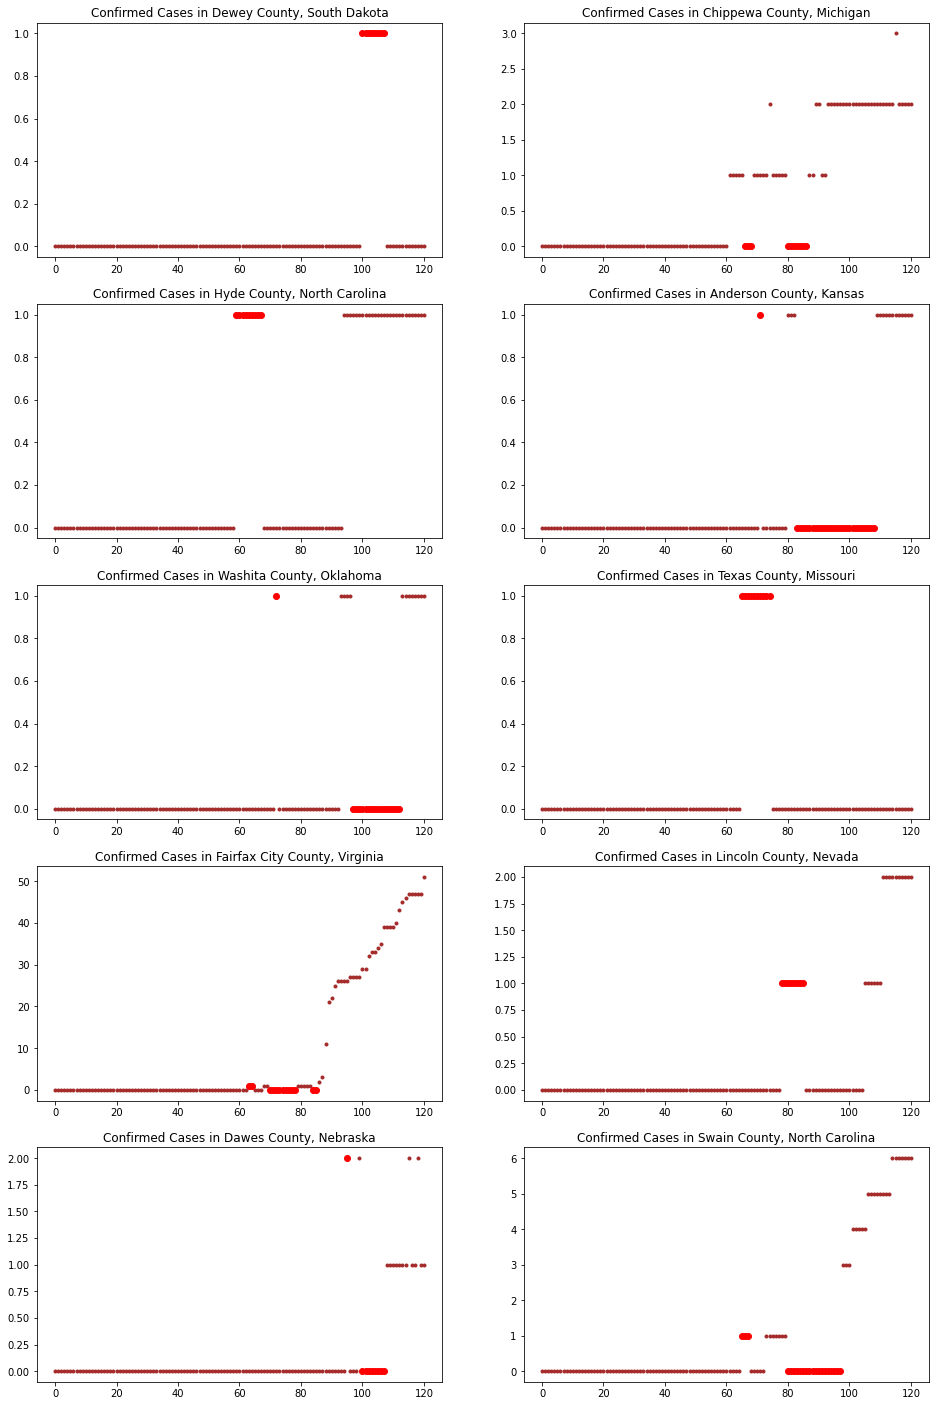

In [28]:
util.graph_examples(cases, "Confirmed", {}, num_to_pick=10, mask=(cases.index.isin(counties_with_outliers.index)))

In [29]:
# The steps we've just done have removed quite a few questionable
# data points, but you will definitely want to flag additional 
# outliers by hand before trusting descriptive statistics about
# any county.

# TODO: Incorporate manual whitelists and blacklists of outliers
#  into this notebook.

# Write out cleaned time series data

By default, output files go to the `outputs` directory. You can use the `COVID_OUTPUTS_DIR` environment variable to override that location.

In [30]:
# Break out our time series into multiple rows again for writing to disk.
cleaned_cases_vertical = util.explode_time_series(cases, dates)
cleaned_cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-17  Wyoming   Weston        6927          0       0          0   
      2020-05-18  Wyoming   Weston        6927          0       0          0   
      2020-05-19  Wyoming   Weston        6927          0       0          0   
      2020-05-20  Wyoming   Weston        6927          0       0          0   
      2020-05-21  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-05-17                  0               0                  0  
      2020-05-18                  0               0                  0  
      2020-05-19                  0               0                  0  
      2020-05-20                  0               0                  0  
      2020-05-21                  0               0                  0  

[380182 rows x 9 columns]

In [31]:
# The outlier masks are stored as integers as a workaround for a Pandas
# bug. Convert them to Boolean values for writing to disk.
cleaned_cases_vertical["Confirmed_Outlier"] = cleaned_cases_vertical["Confirmed_Outlier"].astype(np.bool)
cleaned_cases_vertical["Deaths_Outlier"] = cleaned_cases_vertical["Deaths_Outlier"].astype(np.bool)
cleaned_cases_vertical["Recovered_Outlier"] = cleaned_cases_vertical["Recovered_Outlier"].astype(np.bool)
cleaned_cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-17  Wyoming   Weston        6927          0       0          0   
      2020-05-18  Wyoming   Weston        6927          0       0          0   
      2020-05-19  Wyoming   Weston        6927          0       0          0   
      2020-05-20  Wyoming   Weston        6927          0       0          0   
      2020-05-21  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-05-17              False           False              False  
      2020-05-18              False           False              False  
      2020-05-19              False           False              False  
      2020-05-20              False           False              False  
      2020-05-21              False           False              False  

[380182 rows x 9 columns]

In [32]:
# Write out the results to a CSV file plus a JSON file of type metadata.
cleaned_cases_vertical_csv_data_file = os.path.join(_OUTPUTS_DIR,"us_counties_clean.csv")
print(f"Writing cleaned data to {cleaned_cases_vertical_csv_data_file}")
cleaned_cases_vertical.to_csv(cleaned_cases_vertical_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in cleaned_cases_vertical.dtypes.iteritems()
}

cleaned_cases_vertical_json_data_file = os.path.join(_OUTPUTS_DIR,"us_counties_clean_meta.json")
print(f"Writing metadata to {cleaned_cases_vertical_json_data_file}")
with open(cleaned_cases_vertical_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing cleaned data to outputs/us_counties_clean.csv
Writing metadata to outputs/us_counties_clean_meta.json
